In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!/bin/bash
!kaggle datasets download navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 1.54GB/s]


In [ ]:
!unzip -qq brain-mri-images-for-brain-tumor-detection.zip

In [ ]:
import os
import shutil
import random
from pathlib import Path

def create_brain_mri_dataset(root_dir):
    root_dir = Path(root_dir)

    # Source folders
    yes_dir = root_dir / "yes"
    no_dir = root_dir / "no"

    # New target structure
    base_dir = root_dir / "brain_mri_dataset"

    train_yes = base_dir / "train" / "yes"
    train_no = base_dir / "train" / "no"

    test_yes = base_dir / "test" / "yes"
    test_no = base_dir / "test" / "no"

    val_yes = base_dir / "validation" / "yes"
    val_no = base_dir / "validation" / "no"

    # Create folders
    for d in [train_yes, train_no, test_yes, test_no, val_yes, val_no]:
        d.mkdir(parents=True, exist_ok=True)

    def split_and_copy(src_dir, train_target, test_target, val_target):
        files = [f for f in src_dir.iterdir() if f.is_file()]
        random.shuffle(files)

        total = len(files)
        train_end = int(total * 0.6)
        test_end = train_end + int(total * 0.2)

        train_files = files[:train_end]
        test_files = files[train_end:test_end]
        val_files = files[test_end:]

        # Copy train files
        for file in train_files:
            shutil.copy(file, train_target / file.name)

        # Copy test files
        for file in test_files:
            shutil.copy(file, test_target / file.name)

        # Copy validation files
        for file in val_files:
            shutil.copy(file, val_target / file.name)

    # Process both categories
    split_and_copy(yes_dir, train_yes, test_yes, val_yes)
    split_and_copy(no_dir, train_no, test_no, val_no)

    print("Dataset created successfully at:", base_dir)


In [ ]:
def renameYesFiles():
  yes_dir = Path("/content/brain_tumor_dataset/yes")
  files = os.listdir(yes_dir)  # sort so order is stable
  for i, filename in enumerate(files,start=1):
    # print(str(i),filename)
    newFileName = "yes-" + str(i) + ".jpg"
    os.rename(yes_dir / filename, yes_dir / newFileName)
  print("Yes Folder Sucessfully Renamed")

In [ ]:
def renameNoFiles():
  no_dir = Path("/content/brain_tumor_dataset/no")
  files = os.listdir(no_dir)  # sort so order is stable
  for i, filename in enumerate(files,start=1):
    # print(str(i),filename)
    newFileName = "no-" + str(i) + ".jpg"
    os.rename(no_dir / filename, no_dir / newFileName)
  print("No Folder Sucessfully Renamed")

In [ ]:
renameYesFiles()

Yes Folder Sucessfully Renamed


In [ ]:
renameNoFiles()

No Folder Sucessfully Renamed


In [ ]:
root_path = "/content"
create_brain_mri_dataset(root_path)


Dataset created successfully at: /content/brain_mri_dataset


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory


In [ ]:
import pathlib
new_base_dir = pathlib.Path("brain_mri_dataset")

In [ ]:
train_dataset = image_dataset_from_directory(new_base_dir / "train",image_size=(180, 180),batch_size=32)

Found 151 files belonging to 2 classes.


In [ ]:
test_dataset = image_dataset_from_directory(new_base_dir / "test",image_size=(180, 180),batch_size=32)

Found 50 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(new_base_dir / "validation",image_size=(180, 180),batch_size=32)

Found 52 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
# Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

In [ ]:
# Model Layers
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
  filepath="convnet_from_scratch_with_augmentation.keras",
  save_best_only=True,
  monitor="val_loss")
]

history = model.fit(
 train_dataset,
 epochs=50,
 validation_data=validation_dataset,
 callbacks=callbacks)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.4094 - loss: 0.8086 - val_accuracy: 0.5962 - val_loss: 0.6706
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6181 - loss: 0.6893 - val_accuracy: 0.5962 - val_loss: 0.6647
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5957 - loss: 0.6646 - val_accuracy: 0.5962 - val_loss: 0.6746
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6064 - loss: 0.6766 - val_accuracy: 0.5962 - val_loss: 0.6777
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6194 - loss: 0.6723 - val_accuracy: 0.5962 - val_loss: 0.6435
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6011 - loss: 0.6626 - val_accuracy: 0.5962 - val_loss: 0.6646
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5990 - loss: 0.6517 - val_accuracy: 0.5962 - val_loss: 0.6265
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6043 - loss: 0.6368 - val_accuracy: 0.6154 - val_loss: 0.6298

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"testing accuracy: {test_acc:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7300 - loss: 0.5064 
testing accuracy: 0.720


In [ ]:
testing_image_batch, testing_label_batch = next(iter(test_dataset))

In [ ]:
print(testing_image_batch.shape)
print(testing_label_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
import matplotlib.pyplot as plt
from keras.applications.resnet50 import preprocess_input


In [ ]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
        [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        ]
              )
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

In [ ]:
model.compile(loss="binary_crossentropy",optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),metrics=["accuracy"])

In [ ]:
callbacks = [
        keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_with_resnet.keras",
        save_best_only=True,
        monitor="val_loss")]

In [ ]:
history = model.fit(
                train_dataset,
                epochs=30,
                validation_data=validation_dataset,
                callbacks=callbacks)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6244 - loss: 1.4155 - val_accuracy: 0.5577 - val_loss: 1.3878
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7775 - loss: 0.7465 - val_accuracy: 0.8077 - val_loss: 0.6714
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.8084 - loss: 0.6003 - val_accuracy: 0.8077 - val_loss: 0.6830
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - accuracy: 0.8464 - loss: 0.4461 - val_accuracy: 0.8077 - val_loss: 0.6164
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.8303 - loss: 0.6755 - val_accuracy: 0.8462 - val_loss: 0.6675
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.8813 - loss: 0.4390 - val_accuracy: 0.8077 - val_loss: 0.6446
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9191 - loss: 0.2120 - val_accuracy: 0.8462 - val_loss: 0.6255
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9170 - loss: 0.2444 - val_accuracy: 0.8462 - val_loss: 0.64

In [ ]:
test_model = keras.models.load_model("fine_tuning_with_resnet.keras")
test_loss, test_acc = test_model.evaluate(train_dataset)
print(f"testing accuracy: {test_acc:.3f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9632 - loss: 0.1706
testing accuracy: 0.947


(np.float64(-0.5), np.float64(179.5), np.float64(179.5), np.float64(-0.5))

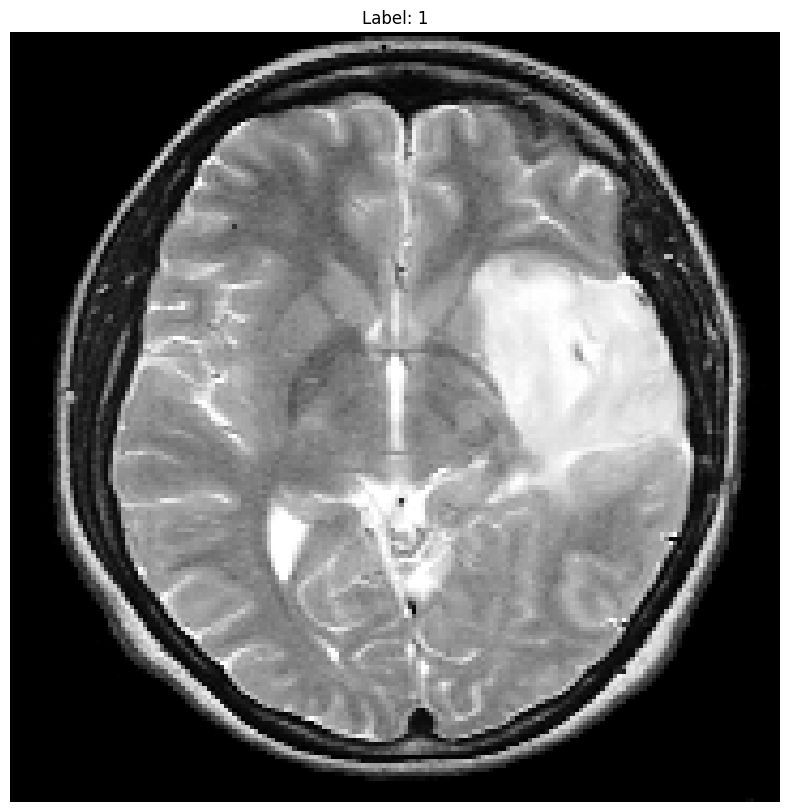

In [ ]:
testingIndex= 10
plt.figure(figsize=(10, 10))
plt.imshow(testing_image_batch[testingIndex].numpy().astype("uint8"))
plt.title(f"Label: {testing_label_batch[testingIndex].numpy().item()}")
plt.axis("off")

In [ ]:
prediction = test_model.predict(testing_image_batch[testingIndex].numpy().reshape(1,180,180,3))
predicted_label = (prediction[0][0] > 0.5).astype("int32")
print(predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1
